In [39]:
import numpy as np
import yfinance as yf
import pandas as pd
import os
import logging
from datetime import datetime
import py_vollib as pv
import py_vollib_vectorized as pvv
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'V', 'DIS']

In [5]:
stock = yf.Ticker(tickers[0])
hist_data = stock.history(period="1mo", interval="5m")
targets = stock.analyst_price_targets

In [6]:
display(hist_data.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-12-30 09:30:00-05:00,274.000000,274.070007,272.790009,272.818512,1047835,0.0,0.0
2025-12-30 09:35:00-05:00,272.815002,273.440002,272.470001,273.160004,331428,0.0,0.0
2025-12-30 09:40:00-05:00,273.170013,273.799988,273.049988,273.320007,273344,0.0,0.0
2025-12-30 09:45:00-05:00,273.309998,273.700012,273.000000,273.600006,215321,0.0,0.0
2025-12-30 09:50:00-05:00,273.600006,273.635010,273.404999,273.630005,145665,0.0,0.0


In [7]:
report_date = "2026-01-21"
file_path = f"/Volumes/SEAGATE/crondata/{report_date}"
expiry_date = "2026-01-30"
options_file = os.path.join(file_path, f"{tickers[0]}_options_{expiry_date}_110002.parquet")

In [8]:
stock_price = hist_data[hist_data.index == '2026-01-21 11:00:00-05:00']
display(stock_price)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-21 11:00:00-05:00,248.169907,248.289993,247.889999,247.999695,288378,0.0,0.0


In [ ]:
def clean_options_data(df):
    df = df[df['lastPrice'] > 0]
    df = df[df['volume'] > df['volume'].quantile(0.5)]
    # df['time_to_expiry'] = (pd.to_datetime(df['expiration']) - pd.to_datetime(report_date)).dt.days / 365
    df = df[['contractSymbol', 'lastPrice', 'strike', 'bid', 'ask', 'type', 'impliedVolatility', 'volume']]
    df['type'] = df['type'].map({ 'call': 'c', 'put': 'p' })
    df['TTE'] = (pd.to_datetime("2026-01-30 16:00:00") - pd.to_datetime("2026-01-21 11:00:00")).days / 365
    return df

In [79]:
#combine with option prices and feed into black scholes to get implied vol (check from builtin and compare)
options_data = pd.read_parquet(options_file)
options_data_new = clean_options_data(options_data)

In [80]:
display(options_data_new)

,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,TTE
12,AAPL260130C00220000,28.20,220.0,28.05,28.55,c,0.433599,91.0,0.024658
16,AAPL260130C00237500,12.85,237.5,12.70,12.85,c,0.375739,37.0,0.024658
17,AAPL260130C00240000,11.05,240.0,10.90,11.00,c,0.372931,319.0,0.024658
18,AAPL260130C00242500,9.42,242.5,9.15,9.30,c,0.370734,149.0,0.024658
19,AAPL260130C00245000,7.80,245.0,7.55,7.70,c,0.365119,521.0,0.024658
20,AAPL260130C00247500,6.20,247.5,6.30,6.35,c,0.365241,1140.0,0.024658
21,AAPL260130C00250000,5.05,250.0,4.95,5.05,c,0.358283,2446.0,0.024658
22,AAPL260130C00252500,3.95,252.5,3.85,3.95,c,0.353156,680.0,0.024658
23,AAPL260130C00255000,3.03,255.0,2.98,3.05,c,0.350348,3837.0,0.024658
24,AAPL260130C00257500,2.28,257.5,2.26,2.30,c,0.347052,511.0,0.024658


In [81]:
print(stock_price['Open'])

Datetime
2026-01-21 11:00:00-05:00    248.169907
Name: Open, dtype: float64


In [82]:
def set_thresholds(row):
    # print(row['strike'])
    if row['type'] == 'c':
        return max(0, stock_price['Open'].values[0] - row['strike'] * np.exp(-.035 * row['TTE']))
    else:
        return max(0, row['strike'] * np.exp(-.035 * row['TTE']) - stock_price['Open'].values[0])

options_data_new['threshold'] = options_data_new.apply(set_thresholds, axis=1)
display(options_data_new)

,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,TTE,threshold
12,AAPL260130C00220000,28.20,220.0,28.05,28.55,c,0.433599,91.0,0.024658,28.359688
16,AAPL260130C00237500,12.85,237.5,12.70,12.85,c,0.375739,37.0,0.024658,10.874784
17,AAPL260130C00240000,11.05,240.0,10.90,11.00,c,0.372931,319.0,0.024658,8.376941
18,AAPL260130C00242500,9.42,242.5,9.15,9.30,c,0.370734,149.0,0.024658,5.879097
19,AAPL260130C00245000,7.80,245.0,7.55,7.70,c,0.365119,521.0,0.024658,3.381254
20,AAPL260130C00247500,6.20,247.5,6.30,6.35,c,0.365241,1140.0,0.024658,0.883410
21,AAPL260130C00250000,5.05,250.0,4.95,5.05,c,0.358283,2446.0,0.024658,0.000000
22,AAPL260130C00252500,3.95,252.5,3.85,3.95,c,0.353156,680.0,0.024658,0.000000
23,AAPL260130C00255000,3.03,255.0,2.98,3.05,c,0.350348,3837.0,0.024658,0.000000
24,AAPL260130C00257500,2.28,257.5,2.26,2.30,c,0.347052,511.0,0.024658,0.000000


In [83]:
options_data_new['implied_vol_bs'] = pvv.implied_volatility.vectorized_implied_volatility(
    price=options_data_new['lastPrice'].values,
    S=stock_price['Open'],
    K=options_data_new['strike'].values,
    t=options_data_new['TTE'].values,
    r=0.035,
    on_error='warn',
    flag=options_data_new['type'].values,
    model='black_scholes',
    return_as='numpy'
)
display(options_data_new.head(5))
display(options_data_new.tail(5))

/Users/stark/Desktop/Projects/Options_analysis/venv/lib/python3.13/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 42]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,TTE,threshold,implied_vol_bs
12,AAPL260130C00220000,28.20,220.0,28.05,28.55,c,0.433599,91.0,0.024658,28.359688,NaN
16,AAPL260130C00237500,12.85,237.5,12.70,12.85,c,0.375739,37.0,0.024658,10.874784,0.386898
17,AAPL260130C00240000,11.05,240.0,10.90,11.00,c,0.372931,319.0,0.024658,8.376941,0.389155
18,AAPL260130C00242500,9.42,242.5,9.15,9.30,c,0.370734,149.0,0.024658,5.879097,0.392596
19,AAPL260130C00245000,7.80,245.0,7.55,7.70,c,0.365119,521.0,0.024658,3.381254,0.385885


,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,TTE,threshold,implied_vol_bs
77,AAPL260130P00260000,13.74,260.0,13.75,13.85,p,0.375006,272.0,0.024658,11.605807,0.396796
78,AAPL260130P00262500,15.80,262.5,15.60,16.10,p,0.396002,58.0,0.024658,14.103650,0.402546
81,AAPL260130P00270000,23.09,270.0,22.35,22.80,p,0.424810,40.0,0.024658,21.597180,0.499346
87,AAPL260130P00285000,40.00,285.0,36.15,38.80,p,0.554204,71.0,0.024658,36.584241,0.912174
92,AAPL260130P00310000,53.45,310.0,61.15,63.75,p,0.793947,34.0,0.024658,61.562675,NaN


In [84]:
options_data_calls = options_data_new[options_data_new['type'] == 'c'].dropna()
options_data_puts = options_data_new[options_data_new['type'] == 'p'].dropna()

In [85]:
def display_iv_comparison(df, built_in_iv_var, custom_iv_var, title):
    plt.figure(figsize=(12, 6))
    plt.plot(df['strike'], df[built_in_iv_var], label='Built-in IV', color='blue')
    plt.plot(df['strike'], df[custom_iv_var], label='Custom IV (Black-Scholes)', color='orange')
    plt.title(title)
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid()
    plt.show()

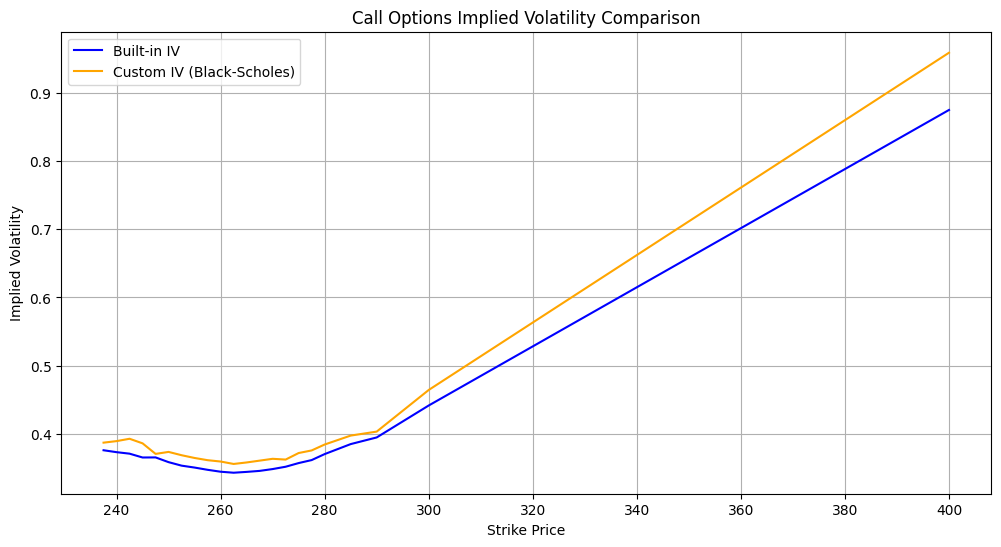

In [86]:
display_iv_comparison(options_data_calls, 'impliedVolatility', 'implied_vol_bs', 'Call Options Implied Volatility Comparison')

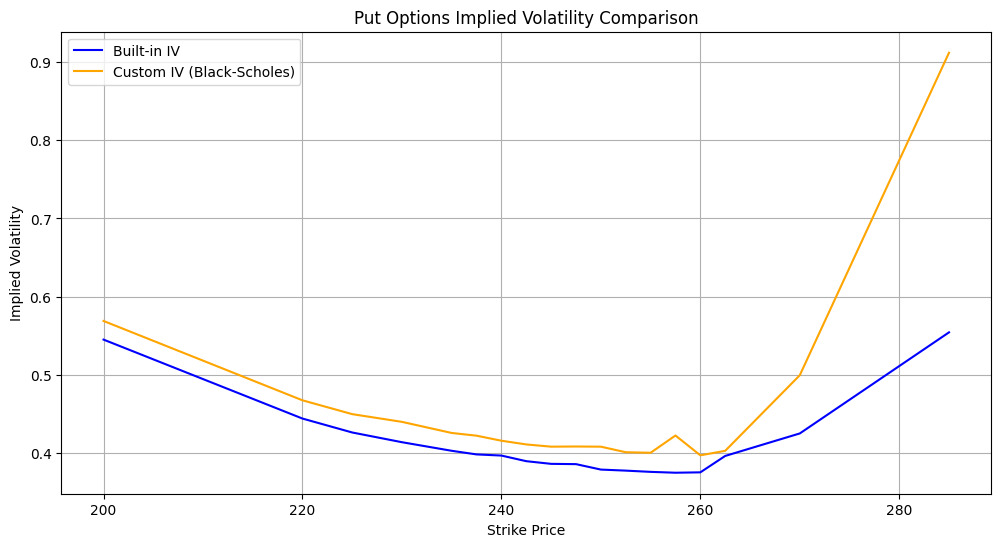

In [87]:
display_iv_comparison(options_data_puts, 'impliedVolatility', 'implied_vol_bs', 'Put Options Implied Volatility Comparison')

In [88]:
# py_vollib_vectorized.models.vectorized_black_scholes(flag, S, K, t, r, sigma, *, return_as='dataframe', dtype=<class 'numpy.float64'>)
def get_theoretical_price(df, flag, S, K, t, sigma, r=0.035):
    price = pvv.models.vectorized_black_scholes(
        flag=df[flag].values,
        S=S,
        K=df[K].values,
        t=df[t].values,
        r=r,
        sigma=df[sigma].values,
        return_as='numpy'
    )
    return price

In [89]:
display(options_data_new)

,contractSymbol,lastPrice,strike,bid,ask,type,impliedVolatility,volume,TTE,threshold,implied_vol_bs
12,AAPL260130C00220000,28.20,220.0,28.05,28.55,c,0.433599,91.0,0.024658,28.359688,NaN
16,AAPL260130C00237500,12.85,237.5,12.70,12.85,c,0.375739,37.0,0.024658,10.874784,0.386898
17,AAPL260130C00240000,11.05,240.0,10.90,11.00,c,0.372931,319.0,0.024658,8.376941,0.389155
18,AAPL260130C00242500,9.42,242.5,9.15,9.30,c,0.370734,149.0,0.024658,5.879097,0.392596
19,AAPL260130C00245000,7.80,245.0,7.55,7.70,c,0.365119,521.0,0.024658,3.381254,0.385885
20,AAPL260130C00247500,6.20,247.5,6.30,6.35,c,0.365241,1140.0,0.024658,0.883410,0.370408
21,AAPL260130C00250000,5.05,250.0,4.95,5.05,c,0.358283,2446.0,0.024658,0.000000,0.373305
22,AAPL260130C00252500,3.95,252.5,3.85,3.95,c,0.353156,680.0,0.024658,0.000000,0.368450
23,AAPL260130C00255000,3.03,255.0,2.98,3.05,c,0.350348,3837.0,0.024658,0.000000,0.364414
24,AAPL260130C00257500,2.28,257.5,2.26,2.30,c,0.347052,511.0,0.024658,0.000000,0.361168


In [90]:
print(options_data_new.shape)
options_theo = options_data_new.copy().dropna()
print(options_theo.shape)

(43, 11)
(40, 11)


In [91]:
def display_price_comparison(df, market_price_var, theo_price_var, title, strike='strike'):
    plt.figure(figsize=(12, 6))
    plt.plot(df[strike], df[market_price_var], label='Market Price', color='blue')
    plt.plot(df[strike], df[theo_price_var], label='Theoretical Price (Black-Scholes)', color='orange')
    plt.title(title)
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid()
    plt.show()

In [92]:
options_theo['theo'] = get_theoretical_price(
    options_theo,
    flag='type',
    S=stock_price['Open'],
    K='strike',
    t='TTE',
    sigma='implied_vol_bs'
)

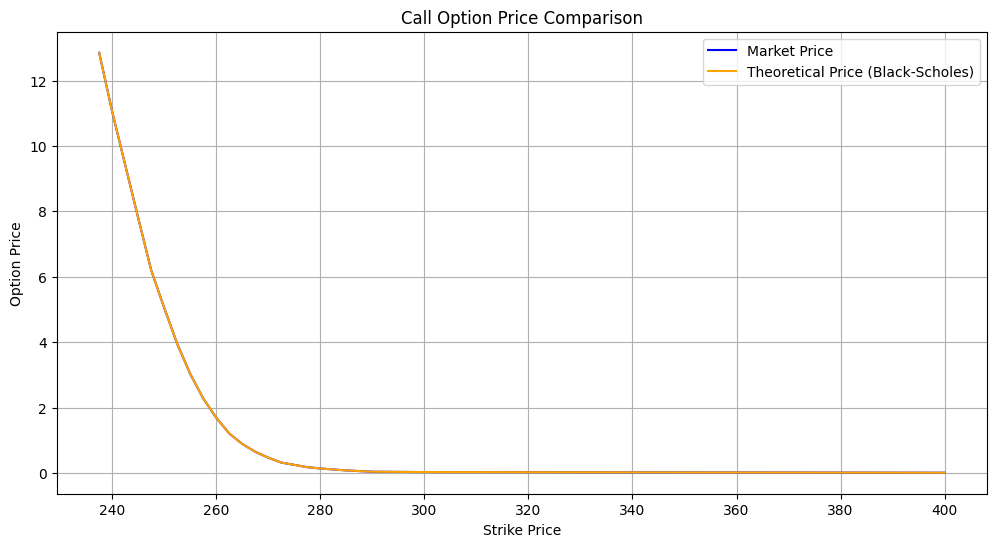

In [95]:
call_theo = options_theo[options_theo['type'] == 'c']
put_theo = options_theo[options_theo['type'] == 'p']
display_price_comparison(call_theo, 'lastPrice', 'theo', 'Call Option Price Comparison')
# display_price_comparison(put_theo, 'lastPrice', 'theo', 'Put Option Price Comparison')

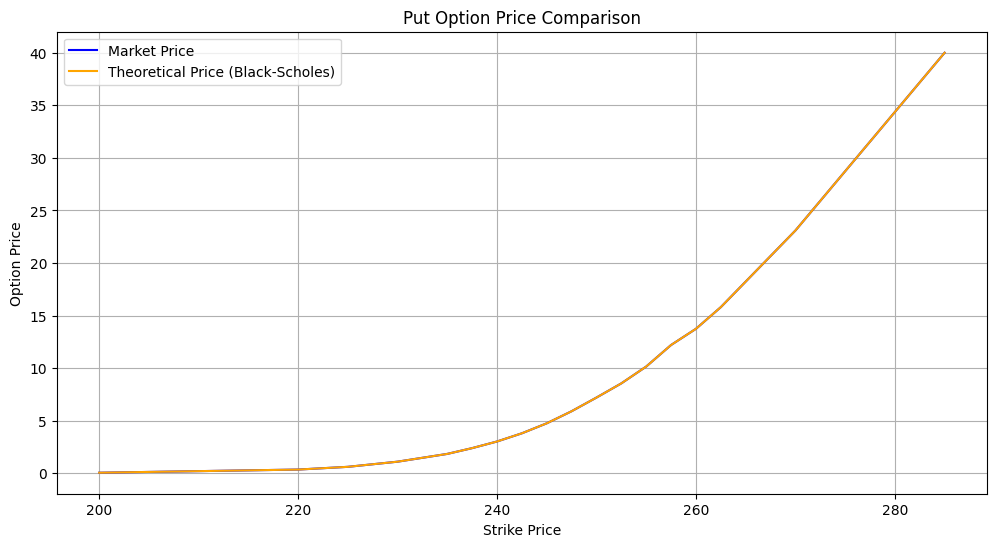

In [96]:
display_price_comparison(put_theo, 'lastPrice', 'theo', 'Put Option Price Comparison')